In this assignment, you need to develop, train and test a model that identifies whether there are sunglasses in a face image. The data Is taken from UCI datasets (https://archive.ics.uci.edu/ml/datasets/CMU+Face+Images).

The samples are given in two folders matching the two classes. You need to develop a CNN model. 
Use the concepts we learn in class: train/validation/test split, grid-search, cross-validation, etc.

Your submission should be a jupyter notebook that has the next sections:
Loading the data (clean, transform if needed). Then train the models to search for optimal hyperparameters.
Finally, report the performance on the test set (think what should be the  evaluation metric(s)).


Answer the next questions:
1. Does the model overfit?
2. What's the effect of batch size? In general, do you see this effect in the current task?
3. What was the optimal optimizer? Explain.

# Imports

In [75]:
import cv2
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from keras import datasets, layers, models
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# Load data

In [ ]:
IMG_WIDTH=32
IMG_HEIGHT=30
IMG_FOLDER=r'Data/'
def create_dataset(img_folder):
  img_data_array=[]
  class_name=[]

  for dir1 in os.listdir(img_folder):
    for file in os.listdir(os.path.join(img_folder, dir1)):
      image_path = os.path.join(img_folder, dir1, file)
      image = cv2.imread( image_path, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), 
                        interpolation = cv2.INTER_AREA)
      image = np.array(image)
      image = image.astype('float32')
      image /= 255
      img_data_array.append(image)
      class_name.append(dir1)
  return img_data_array, class_name

# Extract the image array and class name
img_data, class_name = create_dataset(IMG_FOLDER)
target_dict={k: v for v, k in enumerate(np.unique(class_name))}
# Convert the class_names to their respective numeric value based on the dictionary
target_val = [target_dict[class_name[i]] for i in range(len(class_name))]
# Convert to X - a 3d array (samples, width, height) and y - 0/1
X = tf.cast(np.array(img_data), tf.float64)
y = tf.cast(list(map(int,target_val)),tf.int32)

# Process and transform the data

In [ ]:
# casting to np
x_data = X.numpy()
y_data = y.numpy()
# Set the random seed
random_seed = 42
#split the data for train and test
X_train, X_test, y_train, y_test = train_test_split(x_data,y_data,test_size=0.1, random_state=random_seed)

In [ ]:
print(f"X_train image size: {X_train[0].shape}")

X_train image size: (32, 30)


In [ ]:
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int32), array([278, 283]))

In [ ]:
# Add another 1 chanel for black-white images
input_shape = X_train[0].reshape(32, 30, -1)
input_shape.shape

(32, 30, 1)

In [ ]:
# Inpute shape (image_height, image_width, color_channels)
input_shape = input_shape.shape


# Train the model

In [82]:
def cnn_model(optimizer= 'adam'):
  # Create convolutional base
  model = models.Sequential()
  model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), padding = 'Same',  activation='relu', input_shape=input_shape))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding = 'Same', activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding = 'Same', activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  # model.add(layers.Dropout(0.05))
  model.add(layers.Dense(2, activation='softmax'))
  # Compile and train the model
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [83]:
# create model
model = KerasClassifier(cnn_model,epochs=20, verbose=1)

<ipython-input-83-3e25de317a76>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(cnn_model,epochs=20, verbose=1)


In [84]:
model.build_fn().summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 32, 30, 32)        320       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 16, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 16, 15, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 8, 7, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 8, 7, 64)          36928     
                                                                 
 flatten_15 (Flatten)        (None, 3584)            

In [85]:
# define parameters and values for grid search 
param_grid = {'optimizer' :  ['SGD', 'adam', 'Nadam']}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs = -1, cv = 5).fit(X_train, y_train)

Epoch 1/20
18/18 [==============================] - 2s 65ms/step - loss: 0.6969 - accuracy: 0.5258
Epoch 2/20
18/18 [==============================] - 2s 111ms/step - loss: 0.6861 - accuracy: 0.6078
Epoch 3/20
18/18 [==============================] - 2s 100ms/step - loss: 0.6286 - accuracy: 0.7023
Epoch 4/20
18/18 [==============================] - 1s 66ms/step - loss: 0.4760 - accuracy: 0.7736
Epoch 5/20
18/18 [==============================] - 1s 82ms/step - loss: 0.3795 - accuracy: 0.8431
Epoch 6/20
18/18 [==============================] - 2s 97ms/step - loss: 0.2852 - accuracy: 0.8841
Epoch 7/20
18/18 [==============================] - 1s 63ms/step - loss: 0.2162 - accuracy: 0.9305
Epoch 8/20
18/18 [==============================] - 1s 66ms/step - loss: 0.1822 - accuracy: 0.9269
Epoch 9/20
18/18 [==============================] - 1s 65ms/step - loss: 0.1295 - accuracy: 0.9590
Epoch 10/20
18/18 [==============================] - 1s 64ms/step - loss: 0.1234 - accuracy: 0.9590
Epoch 1

In [86]:
# best parameters - best optimizer
grid.best_params_

{'optimizer': 'adam'}

In [90]:
history = grid.best_estimator_.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_test, y_test))

Epoch 1/20
18/18 [==============================] - 2s 79ms/step - loss: 0.6851 - accuracy: 0.5775 - val_loss: 0.6692 - val_accuracy: 0.6032
Epoch 2/20
18/18 [==============================] - 1s 77ms/step - loss: 0.5908 - accuracy: 0.7077 - val_loss: 0.5271 - val_accuracy: 0.7143
Epoch 3/20
18/18 [==============================] - 2s 112ms/step - loss: 0.4115 - accuracy: 0.7914 - val_loss: 0.3369 - val_accuracy: 0.8571
Epoch 4/20
18/18 [==============================] - 3s 170ms/step - loss: 0.2902 - accuracy: 0.8752 - val_loss: 0.2674 - val_accuracy: 0.8889
Epoch 5/20
18/18 [==============================] - 2s 111ms/step - loss: 0.2936 - accuracy: 0.8734 - val_loss: 0.3011 - val_accuracy: 0.8095
Epoch 6/20
18/18 [==============================] - 3s 149ms/step - loss: 0.1977 - accuracy: 0.9251 - val_loss: 0.3262 - val_accuracy: 0.8254
Epoch 7/20
18/18 [==============================] - 1s 72ms/step - loss: 0.1726 - accuracy: 0.9430 - val_loss: 0.2569 - val_accuracy: 0.9206
Epoch 8/2

# Test the model performance

In [96]:
def loss_func(y_true, y_pred):
    diff = np.abs(y_true - y_pred).max()
    return np.log1p(diff)

In [100]:
# score = model(X_test, y_test, verbose=0)
y_predict = grid.best_estimator_.predict(X_test)
from sklearn.metrics import accuracy_score
print(f'Test loss: {loss_func(y_test, y_predict)}, Test accuracy: {accuracy_score(y_test, y_predict)}')


2/2 [==============================] - 0s 23ms/step
Test loss: 0.6931471805599453, Test accuracy: 0.9841269841269841


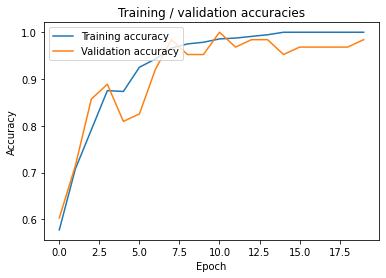

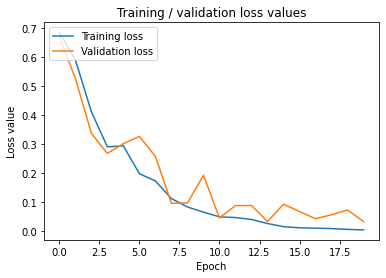

In [101]:
# Visualize model history
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training / validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training / validation loss values')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

# Q1
The accuracy of the model in the training set is similar to the of test set. Both are represnting high accuracy, therefore, the model is not overfitted.

#Q2
The batch size is a hyperparameter that determines the number of samples to work through before updating the model's parameters.<br />
<br />
There are two effects of batch size:<br />
**Computational performance:** <br />Smaller batch sizes may require less memory, but may require more processing time because Larger batch sizes may require more memory, but may require less processing time because the model's parameters need to be updated less frequently.<br />
<br />
**Generalization performance:** <br />Smaller batch sizes can introduce randomness into the model's training, which can lead to better generalization performance, because it allows the model to see different samples each time. Larger batch sizes may lead to worse generalization performance because the model is exposed to similar samples more frequently.

# Q3

The best optimizer is adam. 
first of all, grid search shows that adam is the best for optimizer.
second, adam optimizer implemneting the adaptive lerning rate and it also using the momntum for the gradient.

